Alternative implementation of `generals1a`;
* EnemyCity.should_attack is now a method property which returns random values

### Extracted Story
Several divisions of the Byzantine army are camped outside an enemy city, each division commanded by its own general. Each general observes the enemy and communicates his observation to the others. Each general then combines all the reported observations into a single plan of action (i.e., “attack” or “retreat”), for example, by using a majority vote. Communicating only by messengers, the generals must agree upon a common, and reasonable battle plan, however, one or more of them may be traitors who will try to confuse the others. All loyal generals must carry out the same plan, whereas the traitors may do anything they wish.

### Extracted Story (verbatim)
We imagine that several divisions of the Byzantine army are camped outside an enemy city, each division commanded by its own general. The generals can communicate with one another only by messenger. After observing the enemy, they must decide upon a common plan of action. However, some of the generals may be traitors, trying to prevent the loyal generals from reaching agreement.
...
All loyal generals decide upon the same plan of action... but the traitors may do anything they wish.
...
They loyal generals should not only reach agreement, but should agree upon a reasonable plan.

*Everything below this point is based on the verbatim version of the story.*

### User Stories
* As a GENERAL I want to...
  * make observations on an enemy city to decide upon a plan of action.
  * be able to communicate with other genrals to share our observations.
* As a LOYAL GENERAL I want to...
  * decide upon a reasonable plan of action so that my division does what is best.
  * decide upon the same plan of action as all other loyal generals so order within the army is maintained.
* As a DISLOYAL GENERAL I want to...
  * make false or contradicting observations to prevent the loyal generals from reaching agreement.
* As a MESSENGER I want to...
  * deliver messages between generals/divisons so they can reach upon some agreement.

### Assumptions
* There is only one messenger.
* "Enemy" and "Enemy City" are taken to refer to the same idea.
* A "reasonable plan" is assumed to mean that which wins a majority vote.
* The enemy/city is taken to have no functionality other than just "existing".
  * Whether a city is "attackable" or not is now dependent on each general, i.e., each general cana make a different observation.
* A traitorous general makes random observations to each other general in an attmpt to confuse the loyal generals.
* The observations that generals can make are either "attack" or "retreat".

### Design Decisions
* Enemy cities are simply instances of a class that essentially does nothing (yet).
* Each general works by first making an "objective" decision on an enemy. This is his true observation and not necessarily the one he communicates to the others.
* Generals make "random" observations on a city.
* Traitorous generals randomise the decision that they communicate to others.
* There is (still) no tie breaker for the majority vote... It's not really needed here due to the randomness.
* It's probably worth mentioning that the `EnemyCity` class is now entirely useless as the logic inside `EnemyCity.should_attack` property could be moved into `General.make_observation`.

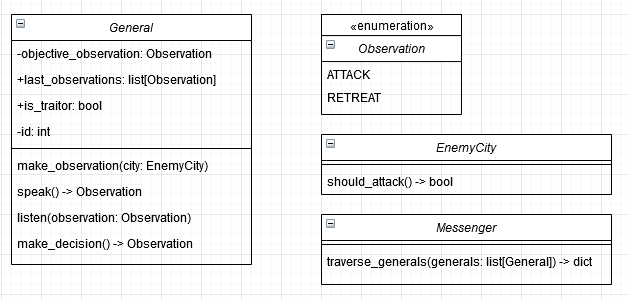

### Interesting Observations
Now that the traitors make random observations to all other generals, the consistency that was previously present is now gone. As a rsult, there is no need for a tie breaker when making decisions. It is now possible for the loyal generals to not reach an agreement. However, we now have the opposite problem as a result of the introduced randomness - now that the *loyal* generals make different observations on the same city, they sometimes (often) fail to reach an agreement even when their decision is **not** affected by the traitors. This is either realistic or not depending on how you look at it. It is intersting to note that if we keep the previous logic whereby traitors simply lied, this problem is somewhat (not completely) alleviated. In such an implementation there is still some randomness because the initial observation that each general makes is random.

Another thing to note is that in this implementation the line between a loyal general and a traitorous one has become somewhat blurred in that both make initially random observations. They loyal generals simply return these first observations whereas the traitors randomise again before returning. Conceptually this mimicks the idea of the traitors simply lying about their initial observation, but logically, there is no difference. The added randomness changes nothing. This is different to the initial implementation where a city was "objectively" attackable or not. It seems the only difference here between the traitors and the loyal generals is that the loyal generals report the same observation to every general, whereas the traitors may not.

In [1]:
# This file is a part of the final year project "Story and Software" (CSC4006).
# Author: Konrad Mosoczy (Queen's University Belfast - QUB)
# https://github.com/konmos/csc4006 (also available on GitLab)
# ------------------------------------------------------------------------------
# This is the BGP notebook implementation 3.

import random
import logging
from enum import Enum, auto
from itertools import combinations
from collections import Counter, defaultdict

In [2]:
logging.basicConfig(level=100, force=True)

In [3]:
class Observation(Enum):
    '''
    Represents an observation that a general has made on a particular city.
    '''
    ATTACK = auto()
    RETREAT = auto()

In [4]:
class EnemyCity:
    @property
    def should_attack(self):
        return random.choice([True, False])

In [5]:
class General:
    '''
    Represents a General who is either loyal or a traitor.
    '''
    # Used for easier representation
    next_id = 0

    def __init__(self, is_traitor=False):
        self._objective_observation = None
        self.last_observations = []
        self.is_traitor = is_traitor

        self._id = General.next_id
        General.next_id += 1
    
    def make_observation(self, city: EnemyCity):
        """Make the initial observation."""
        self._objective_observation = (Observation.RETREAT, Observation.ATTACK)[city.should_attack]
    
    def speak(self):
        """
        Report an observation.
        """
        if not self.is_traitor:
            return self._objective_observation
        
        # Traitors return a random observation
        return random.choice([Observation.RETREAT, Observation.ATTACK])
    
    def listen(self, observation):
        """
        Receive an observation.
        """
        self.last_observations.append(observation)
    
    def make_decision(self):
        # Most common observation.
        return Counter(self.last_observations).most_common(1)[0][0]
    
    def __repr__(self) -> str:
        return f'<General {self._id} [{"t" if self.is_traitor else "l"}]>'

In [6]:
class Messenger:
    @staticmethod
    def traverse_generals(generals):
        '''
        Traverse the network created by pairing every general with every other general.
        Calls the `speak`, and `listen` methods of each `General` instance.
        Effectively creates a node graph of generals and messages.

        :return: The resulting communication graph represented as a dictionary.
        '''
        # {General: {target: message, ...}, ...}
        comms = defaultdict(dict)
        
        for x, y in combinations(generals, 2):
            y_speak = y.speak()
            x_speak = x.speak()
            
            x.listen(y_speak)
            y.listen(x_speak)
            
            comms[y][x] = y_speak
            comms[x][y] = x_speak
        
        return comms

In [7]:
def main(total_generals, num_traitors=-1):
    '''
    Run the main simulation between a number of generals.

    :param total_generals: The TOTAL number of generals
    :param num_traitors: The number of traitors.
        Can be expressed either as...
            int >= 0                 for an absolute size
            float >= 0.0 and <= 1.0  for a percentage of `total_generals`
            int < 0                  for random distribution
    :param should_attack: Should the city be objectively attackable or not.
        (default: random)
    :return: The PoA agreed to by the loyal generals.
        ("retreat", "attack" or None)
    '''
    n_traitors = 0
    
    if isinstance(num_traitors, int):
        if num_traitors >= 0:
            n_traitors = num_traitors
        else:
            n_traitors = int(total_generals * random.random())
    elif isinstance(num_traitors, float) and 0 <= num_traitors <= 1:
        n_traitors = int(total_generals * num_traitors)
    
    generals = [General(False) for _ in range(total_generals - n_traitors)] + \
               [General(True) for _ in range(n_traitors)]
    
    # We now have just a single city object with no explicit `should_attack` argument
    city = EnemyCity()
    
    logging.info(
        f'Running with {total_generals} total generals of which {n_traitors} are traitorous.\n\n'
    )
    
    # Each general makes an objective observation
    for g in generals:
        g.make_observation(city)
    
    # Each general communicates his observation (or not)
    m = Messenger()
    communications = m.traverse_generals(generals)
    
    # Each general comes up with a plan of action
    loyal_poa, agreed_plan = set(), None
    
    for g in generals:
        decision = g.make_decision()
        
        if not g.is_traitor:
            loyal_poa.add(decision)
    
    if len(loyal_poa) != 1:
        logging.info('Loyal Generals cannot agree on a plan of action!!!\n')
    else:
        agreed_plan = loyal_poa.pop()
        logging.info(f'Loyal Generals have agreed on: {agreed_plan}\n')
    
    total_a, total_r = 0, 0

    for g in communications:
        a, r = 0, 0
        
        for msg in communications[g].values():
            if msg is Observation.ATTACK:
                a += 1
            else:
                r += 1
                
        total_a += a
        total_r += r

        logging.debug(
            f'{"[!] " if g.is_traitor else ""}'
            f'General {g._id} has made the objective observation of {g._objective_observation.name}'
            f' and reported ATTTACK {a} times and RETREAT {r} times'
        )
    
    return agreed_plan, total_a, total_r, communications

In [8]:
def test_runner(test_cases, test_runs):
    """
    A simple test runner for this implementation of the BGP.
    
    :param test_cases: a list of tuples specifying what
        tests should be run in the format [(num_generals, num_traitors), ...]
    :param test_runs: the number of times that each test should be run
    """
    # [(num_generals, num_traitors), ...]
    for test in test_cases:
        print(f'\n\nRunning test {test}\n{"-"*20}')

        for _ in range(test_runs):
            plan, a, r, comms = main(*test)
            print(f'\n[PLAN={plan} ATTACK={a} RETREAT={r}]\n')

            for general in comms:
                observations = [0, 0]  # attack, retreat

                for observation in general.last_observations:
                    if observation is Observation.ATTACK:
                        observations[0] += 1
                    else:
                        observations[1] += 1
                
                print(f'{general}: attack={observations[0]} retreat={observations[1]}')

In [9]:
if __name__ == '__main__':
    # m = 10  # 10 traitors
    
    # # The loyal generals should all agree to the same reasonable plan
    # main((3 * m) + 1, m)
    
    # # Here, the loyal generals *should* fail to 
    # # reach agreement or agree to an "unreasonable" plan.
    # # (This doesn't actually happen...)
    # main((3 * m), m)  # Note the missing `+1`
    
    # main(15, 10)

    tests = [
        (10, 0),
        (10, 2),
        (10, 4),
        (10, 6),
        (10, 8),
        (10, 10)
    ]

    test_runner(tests, 3)



Running test (10, 0)
--------------------

[PLAN=Observation.RETREAT ATTACK=27 RETREAT=63]

<General 1 [l]>: attack=3 retreat=6
<General 0 [l]>: attack=3 retreat=6
<General 2 [l]>: attack=3 retreat=6
<General 3 [l]>: attack=3 retreat=6
<General 4 [l]>: attack=2 retreat=7
<General 5 [l]>: attack=3 retreat=6
<General 6 [l]>: attack=3 retreat=6
<General 7 [l]>: attack=2 retreat=7
<General 8 [l]>: attack=3 retreat=6
<General 9 [l]>: attack=2 retreat=7

[PLAN=None ATTACK=45 RETREAT=45]

<General 11 [l]>: attack=5 retreat=4
<General 10 [l]>: attack=4 retreat=5
<General 12 [l]>: attack=4 retreat=5
<General 13 [l]>: attack=5 retreat=4
<General 14 [l]>: attack=5 retreat=4
<General 15 [l]>: attack=4 retreat=5
<General 16 [l]>: attack=4 retreat=5
<General 17 [l]>: attack=4 retreat=5
<General 18 [l]>: attack=5 retreat=4
<General 19 [l]>: attack=5 retreat=4

[PLAN=None ATTACK=45 RETREAT=45]

<General 21 [l]>: attack=4 retreat=5
<General 20 [l]>: attack=5 retreat=4
<General 22 [l]>: attack=5 retre